In [1]:
cd "nilm data\all"

D:\jjenko\nilm data\all


In [2]:
from nilmtk import DataSet
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import datetime
import warnings
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from pyts.image import RecurrencePlot

plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 10)
plt.figure(figsize=(10,30))

dataset_name = "eco"
dataset = DataSet(dataset_name+'.h5')
#dataset.set_window(start='2011-1-17T1800',end='2011-9-18T1900')
#dataset.set_window(start='2012-9-17T1800',end='2012-11-18T1900')

##for redd
#washer dryer is broken, dish washer is rarely used (filter out the noise), electric stove is rarely used, space heater is rarely used 

#manualy_selected_appliances = ["microwave","washer dryer", "dish washer","electric stove","electric oven","fridge","electric space heater","light"]    
#date_range = pd.date_range("2010-1-10T0000", "2012-5-20T0000",freq=f'{step_in_mins}''T')

<Figure size 720x2160 with 0 Axes>

# THE GENERATOR

Prior to running generator, run cell bellow to define functions


In [4]:
#--PARAMTERS--# 
#-step
step_in_mins = 13
#-image
max_dataset_size = 5000 #max number of images per appliance per buidling 
img_size = 100 # means img_size x img_size (igored when using RECC)
n_of_multi_dim_imgs = 5 #change to 0 for normal images (read overlap)
allowed_delta_between_images = 3 #allowed missing images between images 

#-samples
sample_period = 6 # cm be obtained from dataset.metadata["sample_period"] but it is inconsistent
percentage_of_missing_data_allowed = 0.73 # is necessary since sampling rate is inconsistent or samples are missing 

#-brightness
add_brightness = "Y"

#-timeseries
ts_save = "N" # "Y" - save soruce time-series data to output GAF dataset. "N" - do not save ts data
ts_size = round(step_in_mins*60/sample_period) # calculate estimate size of ts

#-trans type
trs_type = "GAF" #GAF or RECU - Gramian Angural Field or Recurrance plot

#-if trans type GAF 
trs_type_gaf = "GASF" # GASF or GADF

#-overlap images (read comments bellow!)
overlap_images = False #True or false 
overlap_images_by_n = 0 #how many images should overlap  **will make n_of_multi_dim_imags shorter by overlap_image_by_n!!!***

#-optimizing 
use_good_sections = "Y"
missing_diff_in_seconds = 10000

if overlap_images==False : overlap_images_by_n = 0; # safety! 

#-buildings
n_buildings = len(dataset.buildings)
multiple_buildings = "Y" # multiple buildings Y on N
selected_building = 2 # is used in case parameter multiple buidlings is N

#-------------------------------------------------------------------------------------------------------------------------------
if multiple_buildings == "Y":
    selected_building = "A"

#-classes and approximate date range

#start and end date are generaly not used, except when using non-optimized verison
if dataset.metadata["name"] == "REDD":
    start_date = "2010-1-10T0000"
    end_date = "2012-5-20T0000"
    #appliances for redd
    manualy_selected_appliances = ["sockets","washer dryer", "dish washer","electric stove","electric oven","fridge","electric space heater","light","air conditioner","CE applaince","electric furnace","air handling unit"]
    #short
    #manualy_selected_appliances = ["microwave"]

elif dataset.metadata["name"] == "iAWE":
    start_date = "2013-1-18T1800"
    end_date = "2013-12-18T1900"
    #applicances for iawe 
    manualy_selected_appliances = ["fridge","television","clothes iron","washing machine","computer","air conditioner"]

elif dataset.metadata["name"] == "UK-DALE":
    start_date = "2013-1-10T0000"
    end_date = "2014-2-20T0000"
    #appliances for ukdale
    manualy_selected_appliances = ["HTPC","dish washer","server computer","washing machine","freezer","fridge freezer","desktop computer","light","computer monitor", "laptop computer", "television", "washer dryer","boiler","fridge"]
    #manualy_selected_appliances = ["dish washer","washer dryer","microwave","boiler","toaster","kettle"]
    #manualy_selected_appliances = ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]
    #short only
    #manualy_selected_appliances = ["microwave","toaster","kettle"]

elif dataset.metadata["name"] == "REFIT":
    start_date = "2013-10-10T0000"
    end_date = "2015-8-20T0000"
    #appliances for refit
    manualy_selected_appliances = ['washing machine','television','microwave','fridge freezer','dish washer','kettle','fridge','computer',"toaster","washer dryer","tumble dryer","unknown","audio system","electric space heater","food processor","broadband router","breadmaker","appliance","dehumidifier","fan","pond pump","games console"]
    #short
    #manualy_selected_appliances = ["microwave","kettle","toaster"]

    #bulding 4 only
    #manualy_selected_appliances = ['fridge freezer','computer','television','tumble dryer','dish washer','washing machine','microwave']
    
elif dataset.metadata["name"] == "ECO":
    start_date = "2012-06-10T0000"
    end_date = "2013-03-20T0000"
    #appliances for eco
    manualy_selected_appliances = ["HTPC","freezer", "fridge", "coffee maker", "computer","laptop computer","lamp","washing machine","dish washer","audio system","air handling unit","broadband router","garden sprinkler"]
    #manualy_selected_appliances = ["kettle","microwave"]

else:
    print("error: dataset used is not compatible with this parser!")
    raise  

date_range = pd.date_range(start_date,end_date,freq=f'{step_in_mins}''T') 

#save paramaters to log file 
print_parameters()

file_name = create_file()

#handle case where:
if trs_type == "RECU":
    img_size = ts_size # recc tf output is same size as input ts

if n_of_multi_dim_imgs != 0:
    #use 4 dims
    gasf_stack_main = np.zeros([0,n_of_multi_dim_imgs,img_size,img_size])
    ts_stack_main = np.zeros([0,n_of_multi_dim_imgs,ts_size])

    if overlap_images == True:
        #multidim size will be a bit smaller, due to overlap
        gasf_stack_main = np.zeros([0,n_of_multi_dim_imgs-overlap_images_by_n,img_size,img_size])
        ts_stack_main = np.zeros([0,n_of_multi_dim_imgs-overlap_images_by_n,ts_size])

else:
    #use 3 dims
    gasf_stack_main = np.zeros([0,img_size,img_size])
    ts_stack_main = np.zeros([0,ts_size])

label_stack = np.zeros(0)
label_building = np.zeros(0)

appliance_weights = np.zeros(0)
healthy_appliances = set()

last_interval = 0
breaker_stack_full = False

max_dataset_size_tmp  = 0
max_dataset_size_tmp_last = 0

all_images_stacked = 0

#counter will count how many images are empty how many are half full and how many are full
counter_empty = 0
counter_halfull = 0
counter_full = 0

counter_noentropy = 0
counter_entropy = 0
counter_nodata = 0
counter_data = 0
counter_deltatohigh = 0
counter_gooddelta = 0

delta_interval =  0
last_interval = 0

#in order not to throw away some appliances 
healthy_image_flag = False

#the idea is to loop through all of the applianes and collect at least N of "max_dataset_size" images for each one
for appliance in manualy_selected_appliances:
    print_log("\n")
    print_log("starting "f"{appliance} ("+str(manualy_selected_appliances.index(appliance)+1)+"/"+str(len(manualy_selected_appliances))+"):")
    print("\n")
    print("starting "f"{appliance} ("+str(manualy_selected_appliances.index(appliance)+1)+"/"+str(len(manualy_selected_appliances))+"):")
    
    #define and reset metric
    applainces_stacked = 0
    
    for building in dataset.buildings:
        
        #check if user selected mutli dim images
        if n_of_multi_dim_imgs != 0:
            #define tmp array to temporary store one image
            gasf_stack_tmp = np.zeros([0,img_size,img_size])
            ts_stack_tmp = np.zeros([0,ts_size])

            #define main array to store n_of_multi_dim_imgs images
            gasf_stack = np.zeros([0,n_of_multi_dim_imgs,img_size,img_size])
            ts_stack = np.zeros([0,n_of_multi_dim_imgs,ts_size])

            if overlap_images == True:
                #multidim size will be a bit smaller
                gasf_stack = np.zeros([0,n_of_multi_dim_imgs-overlap_images_by_n,img_size,img_size])
                ts_stack = np.zeros([0,n_of_multi_dim_imgs-overlap_images_by_n,ts_size])
    
        else:
            #defina array that will store one image
            gasf_stack = np.zeros([0,img_size,img_size])
            ts_stack = np.zeros([0,ts_size])
    
        # use only 1st building if muliple_buildings == "NO"
        if multiple_buildings == "N":
                if int(building)  != selected_building:
                    print("skipping building "f"{building}"" due to parameter muliple_buildings ")
                    continue
        
        dataset.set_window()

        for meter in dataset.buildings[building].elec.submeters().meters:
            
            # get name and instance of an appliance from metadata
            appliance_metadata = meter.appliances[0].metadata
            label = appliance_metadata.get("type")
            instance = appliance_metadata.get("instance")
            
            #select only appliance that is selected (main loop)
            if label != appliance : continue

            #max_dataset_size_tmp = max_dataset_size + gasf_stack.shape[0]
            last_dataset_size = gasf_stack.shape[0]
            
            #get goodsections of the appliance
            if use_good_sections == "Y": #good sections speed up the process
                try:
                    good_sections = get_good_sections(missing_diff_in_seconds) #array of sections with start and end date 
                except:
                    print("good sections error")
                    print_log("good sections error")
                    good_sections = [[start_date],[end_date]] # use whole interval in case of an error 
                    continue
            
            else: # do not use good sections

                good_sections = [[start_date],[end_date]] #good section is simply array from start to end
                
            #needed for progress bar
            N_of_sections = len(good_sections[0]) 
            section_counter = 0
            
            #set breaker for when stack is full
            breaker_stack_full = False

            for section in zip(good_sections[0],good_sections[1]):
                                
                section_counter += 1
            
                #date range
                date_range = pd.date_range(section[0], section[1],freq=f'{step_in_mins}''T')

                #define number of dates inside sections
                N_of_dates = len(date_range)-2
                
                # http://nilmtk.github.io/nilmtk/master/_modules/nilmtk/stats/goodsections.html 
                if N_of_dates < 2: continue

                #break out of two for loops (interval and meters ) breaaker_stack_full flag gets set few lines lower
                if breaker_stack_full:
                    #print("breaker, full!")
                    break
                
                for interval in range(N_of_dates):
 
                    print("\r",
                        " data procesed: ",round(100*section_counter/(N_of_sections),2),"% ",
                        " data procesed per section: ",round(100*interval/(N_of_dates-1),2),"% ",
                        " finished: ",round(100*((gasf_stack.shape[0])/max_dataset_size),2),"% | ",
                        " building ",building," | ",
                        end="")

                    #check if dataset size is larger than specified then set break flag to break out of two loops
                    if gasf_stack.shape[0] >= (max_dataset_size):
                        print("max DS size reached size of "f"{max_dataset_size}"", skipping!")   
                        print_log("max DS size reached size of "f"{max_dataset_size}"", skipping! dataset size: ", gasf_stack.shape[0])
                        breaker_stack_full = True
                        break
        
                    #try to get data else continue   
                    try:
                        ts = get_clean_data()
                    except:
                        continue
                    
                    #trasform clean ts
                    X_gasf = trasfrom_ts(ts)

                    #append trasformed ts
                    append_images(X_gasf)

                    if interval == N_of_dates-2:
                        print_log("last interval, dataset size: ", gasf_stack.shape[0])

        #save images to hdf5
        group_path = f"{dataset_name}""/"f"{appliance}""/"f"{building}"""
        
        if gasf_stack.shape[0] > 0:
            store_many_hdf5(gasf_stack[...,np.newaxis],group_path,"gaf",force_del="yes")
            #per appliances
            applainces_stacked += gasf_stack.shape[0]
            #all together
            all_images_stacked += gasf_stack.shape[0]

            healthy_appliances.add(appliance)
            if ts_save == "Y":
                store_many_hdf5(ts_stack,group_path,"ts",force_del="yes")

        else:
            print("empty for building",building,"appliance",appliance)
  

        print("finished building N",building)#,"status: data procesed: ",round(section_counter/(N_of_sections),2),"% ")
        print_log("finished building N",building)#,"status: data procesed: ",round(section_counter/(N_of_sections),2),"% ")

       
    print_log("")
    print_log("number of images (per appliance) stacked: "f"{applainces_stacked}")
    print("")
    print("number of images (per appliance) stacked: "f"{applainces_stacked}")

    print_log("finished "f"{appliance}")
    print("finished "f"{appliance}")
    
    print("\n")
    print_log("\n")


print_log("num of images stored: ", all_images_stacked)
print("num of images stored: ", all_images_stacked)
print_log("appliances stored: ", healthy_appliances)
print("appliances stored: ", healthy_appliances)

creating new file! ...


starting kettle (1/2):


In [3]:
path = "D:/jjenko/nilm data/GAF_DS/"

def print_parameters():
    print_log("dataset name: ",dataset.metadata["name"],", date : ",datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')," \n"

    "using data from ",date_range[0]," to ", date_range[-1]," \n"

    " using appliances: ",manualy_selected_appliances,"\n"

    " transtype: "f"{trs_type}","\n"
    " gaf trans type: "f"{trs_type_gaf}","\n"

    " windows size in mins: "f"{step_in_mins}","\n"
    " image size in pixels: "f"{img_size}","\n"

    " sample period: "f"{sample_period}","\n"

    " number if images that are stacked together and in series(series!): "f"{n_of_multi_dim_imgs}","\n"
    " allowed max delta between images  "f"{allowed_delta_between_images}","\n"

    " added brightness:  "f"{add_brightness}","\n"

    " overlap multidim images: "f"{overlap_images}","\n"
    " overlap multidim images by number of: "f"{overlap_images_by_n}","\n"
    " true number of images stacked together due to overlaping is: "f"{n_of_multi_dim_imgs-overlap_images_by_n}","\n"

    " save source timeseries: "f"{ts_save}","\n"

    " number of appliances: "f"{len(manualy_selected_appliances)}","\n"
    " number of buildings: "f"{n_buildings}","\n"

    " max number of images per appliance per building: "f"{max_dataset_size}","\n"
    " max number of images per appliance: "f"{max_dataset_size*n_buildings}","\n"
    " max number of images (real number is always smaller): "f"{max_dataset_size*n_buildings*len(manualy_selected_appliances)}","\n"

    " include multiple buildings (Y for Yes N for No): "f"{multiple_buildings}","\n"
    " building selected: "f"{selected_building}","\n"

    " using optimized version with good sections: " f"{use_good_sections}","\n"
    " max time difference between timestamps [seconds]:" f"{missing_diff_in_seconds}","\n"
    )

def print_log(*args, **kwargs):
    #print(*args, **kwargs)
    with open(f'{path}'f'{dataset_name}''output.txt','a') as file:
        print(*args, **kwargs, file=file)

def create_file():
    
    if overlap_images == True:
        overlap_images_str="Y"
    else:
        overlap_images_str="N"

    trs_type_cp = trs_type
    if trs_type_cp == "GAF":
        trs_type_cp = trs_type_gaf

    if ts_save == "Y":
        file_name =f"{dataset_name}""_H_"f"{trs_type_cp}""_"f"{step_in_mins}""m_"f"{img_size}""S"f"{n_of_multi_dim_imgs-overlap_images_by_n}""X_"f"{ts_save}""-TS_"f"{len(manualy_selected_appliances)}""A"f"{max_dataset_size}""N_"f"{selected_building}B""_"f"{overlap_images_str}""-O_Y-S"
    else:
        file_name =f"{dataset_name}""_H_"f"{trs_type}""_"f"{step_in_mins}""m_"f"{img_size}""S"f"{n_of_multi_dim_imgs-overlap_images_by_n}""X_"f"{len(manualy_selected_appliances)}""A"f"{max_dataset_size}""N_"f"{selected_building}B""_"f"{overlap_images_str}""-O_Y-S_AVG-"f"{add_brightness}"

    #check if file exists
    try:
        file = h5py.File(path+file_name+".hdf5","r")
        print("file exists!")
        file.close()

    except:
        print("creating new file! ...")
        file = h5py.File(path+file_name+".hdf5", "w")
        
        file.close()

   

    return file_name

def create_hdf5_group(group_name): #groups are appliances such as fridge or toaster
    

    file = h5py.File(path+file_name+".hdf5", "a")
    dataset = file.create_group(f"{group_name}")
    file.close()


def store_single_hdf5(data, file_id, group_name): 

    """
    Stores single image to HDF5
    """     
    file = h5py.File(path+file_name+".hdf5", "a")
    group = file[f"{group_name}"]
    
    try:
        group.create_dataset(f"{file_id}",np.shape(data),data = data)  
    except:
        del group[f"{file_id}"]
        group.create_dataset(f"{file_id}",np.shape(data),data = data)
        print("  replaced "f"{file_id}""!")
   
    file.close()

def store_many_hdf5(images,group_name,image_set_name,**kwargs):
    """
    Stores multiple images to HDF5
    **kwargs(force_del="yes" to replace existing db w/o prompt)
    """     
    #define some parameters
    num_images = len(images)
    force_del_flag = kwargs.get('force_del', None)# we need it, if "store many" is frequently called
    
    label_flag = kwargs.get('labels', None)# we need it, if "store many" is frequently called

    # read HDF5 file
    try:
        file = h5py.File(path+file_name+".hdf5", "a")
    except:
        print("file not found!")
    
    
    # open specified group
    try:
        group = file[f"{group_name}"]
    except:
        #if if does not exist create it
        group = file.create_group(f"{group_name}")
        
     
    #check if ds already exists, then prompt user
    for name in group:
        if str(name) == str(image_set_name):
            if force_del_flag == "yes":
                print("  removed "f"{name}""!")   
                del group[name]
            else:
                print("Dataset '"f"{name}" "' already exists in " f"{file_name}""/"f"{group_name}")
                
                ans = input("Do you want to replace existing dataset? (y,n) Press enter to contine")
                    
                if ans == "y":
                    print("  removed "f"{name}""!")   
                    del group[name]
                else:
                    print("  quiting! ") 
                    raise

    # Create a dataset in the group       
    print("storing... samples to store: "f"{num_images}")
    
    if label_flag == True:
        #save labels as integers. If sentence needed in case no labels are provided
        dataset = group.create_dataset(f"{image_set_name}", np.shape(images), h5py.h5t.H5T_STD_I8BE , data=images)
    else:
        dataset = group.create_dataset(f"{image_set_name}", np.shape(images), h5py.h5t.IEEE_F32LE , data=images)
    
    file.close()
    print("finshed. stored to " f"{file_name}""/"f"{group_name}""/"f"{image_set_name}")


def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.

    """
    images = []
    


    # Open the HDF5 file
    file = h5py.File(path+file_name+".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images

def get_good_sections(diff_in_seconds):
    
    dataset.set_window()
    df = next(meter.load(physical_quantity='power'))
    timestamps = df.index.view(np.int64)//10**9

    good_sections_start = []
    good_sections_stop = []

    good_sections_start.append(df.index[0].replace(tzinfo=None))

    for i in range(len(timestamps[0:-2])):
        
        diff = timestamps[i+1] - timestamps[i]
        
        if diff > diff_in_seconds:
            good_sections_stop.append(df.index[i].replace(tzinfo=None))
            
            good_sections_start.append(df.index[i+1].replace(tzinfo=None))

    good_sections_stop.append(df.index[-1].replace(tzinfo=None))
    good_sections = [good_sections_start,good_sections_stop]
    
    return good_sections

def get_clean_data():
    global counter_data,counter_nodata,counter_halfull,counter_empty,counter_full,counter_noentropy,counter_entropy,healthy_image_flag
    #try to read from dataset
    try:
        dataset.set_window(start=date_range[interval],end=date_range[interval+1])
        df = next(meter.load(physical_quantity='power'))
        counter_data +=1
    except:
        counter_nodata +=1
        #uncomment fo debug
        #print("problem, no data for "+appliance+"!")
        raise ValueError
    
    #do some metric calcs in order to determine if selected window needs to be dropped
    metric = (60*step_in_mins)/sample_period # will adjust automaticly
    if len(df) < percentage_of_missing_data_allowed*metric:# -> manualy select %
        #uncomment for debug
        
        if len(df) != 0:
            counter_halfull += 1
            #     print("skipped: "+str(date_range[interval])+" had only "+str(len(df))+" out of "+str(metric)+" points ("+str(int(100*(len(df))/metric))+"%)")
        else: 
            counter_empty += 1

        raise ValueError
    else:
        counter_full += 1
    
    #read power data and write it to timeseries
    try:
        ts = df.fillna(0).power.active.values.transpose()
    except:
        print("no active power!")
        print_log("no active power!")
        try:
            print("using apparent power!")
            print_log("using apparent power!")
            ts = df.fillna(0).power.apparent.values.transpose()
        except:
            print("no apparent power!")
            print_log("no apparent power!")
            raise ValueError

    #check if all values in an array are equal to 0
  
    All_equal = np.all(ts==ts[0])
    #temporary
    All_lessthan = np.all(ts < 15 ) #if consumed power is lower than 15 watts (gets rid of noise and dark current. No device used uses less than 15W)

    if  All_equal or All_lessthan :
        #print("skipped due all zero or all one: timeseries:")
        #if all values are 0 then skip
        counter_noentropy +=1
                
        raise ValueError

    else:
        #healthy image here
        healthy_image_flag = True
        counter_entropy += 1
    
    
    
    return ts


def trasfrom_ts(ts):

    global ts_pad
    #calculate mean value of timeseries, that will be multiplied to the matrix. 
    
    with warnings.catch_warnings():
        warnings.filterwarnings("error")
        try:
            ts_mean = ts[ts != 0].mean()
        except RuntimeWarning:
            ts_mean = 0
    #do some timeseries reshaping and padding 
    #add new axis to for padding and gafs
    ts = ts[np.newaxis,:]
    if ts.shape[1] <= ts_size:
        ts_pad = np.pad(ts, [(0,0),(0, ts_size-ts.shape[1])], 'constant')
    else:
        #handle edge case
        ts_pad = ts[:,:ts_size]


    #recurrence transform
    if trs_type == "RECU":
        rp = RecurrencePlot(threshold=None)
        X_gasf = rp.fit_transform(ts_pad)

    #gaf transform
    if trs_type == "GAF":
        
        # Transform the time series into Gramian Angular Fields
        if trs_type_gaf == "GASF":
            gasf = GramianAngularField(image_size=img_size, method='summation')
            X_gasf = gasf.fit_transform(ts_pad)

        if trs_type_gaf == "GADF":
            gadf = GramianAngularField(image_size=img_size, method='difference')
            X_gasf = gadf.fit_transform(ts_pad)
    
    #multiply mean (exluding zero) has similar effect as image brightness
    if add_brightness == "Y":
        X_gasf = X_gasf*ts_mean
    
    return X_gasf
        
def append_images(X_gasf):

    global gasf_stack, gasf_stack_tmp,last_interval,ts_stack,ts_stack_tmp,counter_gooddelta,counter_deltatohigh,healthy_image_flag
    
    #part where we save converted images
    if len(gasf_stack.shape) == 4:

        #append as multi dimensonal images 
        if gasf_stack_tmp.shape[0] < n_of_multi_dim_imgs:
            
            #images in multi dim array must be in strict series order
            delta_interval = interval - last_interval 
            last_interval = interval
            
            if delta_interval <= allowed_delta_between_images: 

                #append, images are strictly in series
                gasf_stack_tmp = np.append(gasf_stack_tmp,X_gasf,axis=0)
                ts_stack_tmp = np.append(ts_stack_tmp,ts_pad,axis=0)
                #print("series di,", delta_interval)
                counter_gooddelta +=1
            else:

                #reset stack to 0
                ts_stack_tmp = np.zeros([0,ts_size])
                gasf_stack_tmp = np.zeros([0,img_size,img_size])
                #print("skip di,", delta_interval)
                counter_deltatohigh += 1

        else:
            #full 
            
            #check if any image in stack includes healthy image (only for short on time appliances)
            if healthy_image_flag:

                if overlap_images == True:
                    #overlap
                    gasf_stack_tmp_new_axis = gasf_stack_tmp[np.newaxis,0:len(gasf_stack_tmp)-overlap_images_by_n] #add new axis for compatability 
                    gasf_stack = np.append(gasf_stack,gasf_stack_tmp_new_axis,axis=0)
                    
                    ts_stack_tmp_new_axis = ts_stack_tmp[np.newaxis,0:len(gasf_stack_tmp)-overlap_images_by_n] #add new axis for compatability
                    ts_stack = np.append(ts_stack,ts_stack_tmp_new_axis,axis=0)
                    
                    #save some values that will overlap
                    gasf_stack_tmp = gasf_stack_tmp[len(gasf_stack_tmp)-overlap_images_by_n:]
                    ts_stack_tmp = ts_stack_tmp[len(ts_stack_tmp)-overlap_images_by_n:]
                    
                
                else:
                    #do not overlap
                    gasf_stack_tmp = gasf_stack_tmp[np.newaxis, ...] #add new axis for compatability
                    gasf_stack = np.append(gasf_stack,gasf_stack_tmp,axis=0)
                    
                    ts_stack_tmp = ts_stack_tmp[np.newaxis, ...] #add new axis for compatability
                    ts_stack = np.append(ts_stack,ts_stack_tmp,axis=0)

                    #reset stack to 0
                    ts_stack_tmp = np.zeros([0,ts_size])
                    gasf_stack_tmp = np.zeros([0,img_size,img_size])
            else: 
                #reset stack to 0
                ts_stack_tmp = np.zeros([0,ts_size])
                gasf_stack_tmp = np.zeros([0,img_size,img_size])
            
            healthy_image_flag = False
    else:
        #append as ordinary images
        gasf_stack = np.append(gasf_stack,X_gasf,axis=0)
        ts_stack = np.append(ts_stack,ts_pad,axis=0)


# DEBUG AREA

In [ ]:
## nofdatest to number of samples
#3 if stavek start end 
# komentiraj arbitrarne odločitve 
# assert poglej!!
#  cooment                   #check if dataset size is larger than specified

In [5]:
dataset.metadata

{'meter_devices': {'current_cost': {'max_sample_period': 300,
   'measurements': [{'type': 'active',
     'upper_limit': 5000,
     'lower_limit': 0,
     'physical_quantity': 'power'}],
   'description': None,
   'sample_period': 6},
  'EM6400': {'max_sample_period': 300,
   'description': 'Multifunction meter for feeders',
   'manufacturer_url': 'http://www.schneider-electric.com/',
   'model': 'EM6400',
   'measurements': [{'type': 'active',
     'upper_limit': 10000,
     'lower_limit': 0,
     'physical_quantity': 'power'},
    {'type': 'apparent',
     'upper_limit': 10000,
     'lower_limit': 0,
     'physical_quantity': 'power'},
    {'type': 'reactive',
     'upper_limit': 10000,
     'lower_limit': 0,
     'physical_quantity': 'power'},
    {'type': 'apparent',
     'upper_limit': 70,
     'lower_limit': 0,
     'physical_quantity': 'frequency'},
    {'type': 'apparent',
     'upper_limit': 270,
     'lower_limit': 0,
     'physical_quantity': 'voltage'},
    {'type': None,
 

In [17]:
#counters represent data as it goes through generator
print("REPORT FOR: ",manualy_selected_appliances)
all1 = counter_empty + counter_halfull + counter_full
print("data lost due to missing data")
print("all",all1)
print("empty",counter_empty, "avg data %",round(100*(counter_empty/all1),2))
print("half full",counter_halfull, "avg data %",round(100*(counter_halfull/all1),2) )
print("full",counter_full,"%",round(100*(counter_full/all1),2))

print("---------")
all3 = counter_entropy+counter_noentropy
print("data lost because it has low entropy or is lower than 10W")
print("all entrop",all3," % of input",round(100*all3/all1,2))
print("high entrop",counter_entropy,"%",round(100*(counter_entropy/all3),2))
print("low entrop",counter_noentropy,"%",round(100*(counter_noentropy/all3),2))

print("---------")
all2 = counter_deltatohigh + counter_gooddelta
print("datalost when stacking")
print("all delta",all2," % of input",round(100*all2/all1,2))
print("good delta",counter_gooddelta,"%",round(100*(counter_gooddelta/all2),2))
print("not good delta",counter_deltatohigh,"%",round(100*(counter_deltatohigh/all2),2))
print("---------")
print("")
print("output %",100*all_images_stacked/all1)

REPORT FOR:  ['HTPC']
data lost due to missing data
all 94829
empty 88 avg data % 0.09
half full 136 avg data % 0.14
full 94605 % 99.76
---------
data lost because it has low entropy or is lower than 10W
all entrop 94605  % of input 99.76
high entrop 2 % 0.0
low entrop 94603 % 100.0
---------
datalost when stacking
all delta 86744  % of input 91.47
good delta 78827 % 90.87
not good delta 7917 % 9.13
---------

output % 0.0


In [ ]:
#(debug)graph first portion of the seleted range
# n = 18
# ukdale.set_window(start=date_range[n],end=date_range[n+1])
# elec = ukdale.buildings[1].elec
# fridge = elec['fridge']
# fridge.available_columns()
# df = next(fridge.load(physical_quantity='power'))
# print(len(df))
# fig, ax = plt.subplots()
# ax.plot(df)
# ax.set(xlabel='time (min)', ylabel='P', title='P')
# ax.grid()

In [20]:
ts

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

HTPC 1


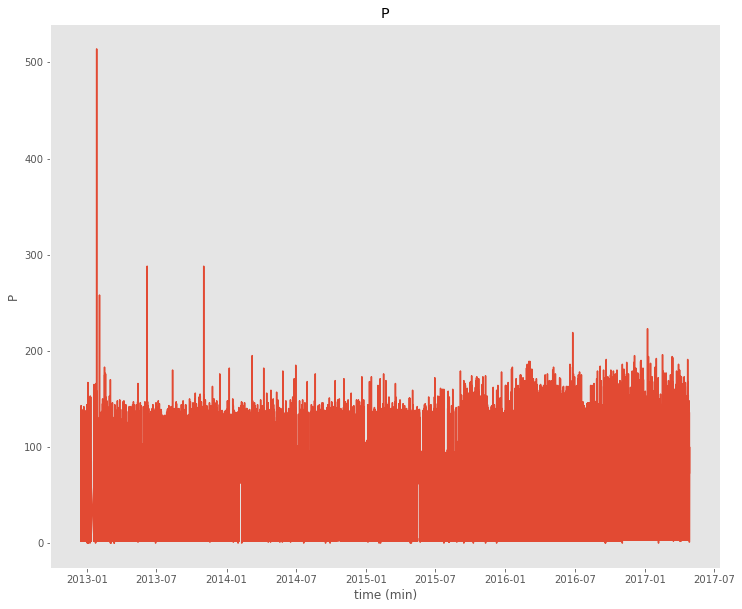

In [22]:
meter = dataset.buildings[1].elec.submeters().meters[7]
dataset.set_window()
df = next(meter.load(physical_quantity='power'))

appliance_metadata = meter.appliances[0].metadata
label = appliance_metadata.get("type")
instance = appliance_metadata.get("instance")
print(label,instance)

#df = df.power.active #for iawe
fig, ax = plt.subplots()
ax.plot(df.fillna(0))
 
ax.set(xlabel='time (min)', ylabel='P', title='P')
ax.grid()

elec = dataset.buildings[2].elec#df.power.active[1900:1950]

In [24]:
df

physical_quantity,power
type,active
2012-12-14 22:21:32+00:00,79.0
2012-12-14 22:21:38+00:00,65.0
2012-12-14 22:21:44+00:00,72.0
2012-12-14 22:21:50+00:00,70.0
2012-12-14 22:21:57+00:00,69.0
...,...
2017-04-26 18:35:22+01:00,76.0
2017-04-26 18:35:30+01:00,73.0
2017-04-26 18:35:37+01:00,74.0


In [23]:
ts = df.fillna(0).power.active.values.transpose()

In [25]:
len(ts)

19543268

In [26]:
more = ts[ts > 100]
print(len(more))
print(len(ts))
print("%",100*len(more)/len(ts))

5876
19543268
% 0.030066619359669016


In [182]:
dataset.set_window()
#fridge
meter = dataset.buildings[2].elec.submeters().meters[1]
df = next(meter.load(physical_quantity='power'))

In [8]:
for building in dataset.buildings:
#building = 
        print("------",building)
        count = 0
        for meter in dataset.buildings[building].elec.submeters().meters:
                count += 1
                # get name and instance of an appliance from metadata
                appliance_metadata = meter.appliances[0].metadata
                label = appliance_metadata.get("type")
                instance = appliance_metadata.get("instance")
                print(label,instance,count)
                

------ 1
boiler 1 1
solar thermal pumping station 1 2
laptop computer 1 3
washer dryer 1 4
dish washer 1 5
television 1 6
light 1 7
HTPC 1 8
kettle 1 9
toaster 1 10
fridge freezer 1 11
microwave 1 12
computer monitor 1 13
audio system 1 14
breadmaker 1 15
audio amplifier 1 16
broadband router 1 17
light 3 18
soldering iron 1 19
ethernet switch 1 20
vacuum cleaner 1 21
light 4 22
light 5 23
light 16 24
light 6 25
tablet computer charger 1 26
active subwoofer 1 27
light 7 28
radio 1 29
light 8 30
wireless phone charger 1 31
light 9 32
mobile phone charger 1 33
light 10 34
coffee maker 1 35
radio 2 36
mobile phone charger 2 37
hair dryer 1 38
hair straighteners 1 39
clothes iron 1 40
oven 1 41
computer 1 42
light 11 43
light 12 44
baby monitor 1 45
charger 1 46
light 13 47
light 14 48
light 15 49
desktop computer 1 50
fan 1 51
printer 1 52
------ 2
laptop computer 1 1
computer monitor 1 2
active speaker 1 3
computer 1 4
broadband router 1 5
external hard disk 1 6
kettle 1 7
rice cooker 1 

In [11]:
#for n in range(len(dataset.buildings[building].elec.submeters().meters)):

meter = dataset.buildings[1].elec.submeters().meters[7]
    
# get name and instance of an appliance from metadata
appliance_metadata = meter.appliances[0].metadata
label = appliance_metadata.get("type")
instance = appliance_metadata.get("instance")
print(label,instance)

HTPC 1
